# This is going to be awesome

### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
from matplotlib.colors import ListedColormap
from statsmodels.formula.api import ols
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
colors = ['#BDDDFC', '#88BDF2', '#6A89A7', '#384959']
color_palett = ListedColormap(sns.color_palette(['#BDDDFC', '#AAC8E5', '#97B3CD', '#849EB6', '#71889F', '#5E7388', '#4B5E70', '#384959']))

In [3]:
pre = pd.read_csv('data/pre.csv', quotechar='\t')
during = pd.read_csv('data/during.csv', quotechar='\t')
post = pd.read_csv('data/post.csv', quotechar='\t')
pre.columns

Index(['"Timestamp', '""Participant ID (top-right corner of the screen)""',
       '""How old are you?""', '""Gender?""',
       '""What describes you the best?""',
       '""How comfortable are you in expressing emotions?""',
       '""Have you ever played with the drummer bot dB before?""',
       '""How much prior experience do you have with interactive musical interfaces (e.g. sensor systems. digital control devices)?""',
       '""How often do you use AI tools for creativity (e.g. writing. coding. music. fine arts. food recipes. etc.)?""',
       '""Please indicate if you have any of the following health problems.""";'],
      dtype='object')

### Filter data

In [4]:
# inspect for test data
mask = np.column_stack([pre[col].str.contains('test', na=False) for col in pre])
print(pre[mask])

mask = np.column_stack([pre[col].str.contains('Test', na=False) for col in pre])
print(pre[mask])

                        "Timestamp  \
0     "2024/11/04 5:15:10 PM GMT+1   
50    "2024/11/07 2:09:46 PM GMT+1   
63   "2024/11/08 12:47:28 PM GMT+1   
128  "2024/11/11 11:03:28 AM GMT+1   
131  "2024/11/11 11:29:10 AM GMT+1   
135  "2024/11/11 11:55:54 AM GMT+1   
137  "2024/11/11 12:11:12 PM GMT+1   
140  "2024/11/11 12:33:52 PM GMT+1   

    ""Participant ID (top-right corner of the screen)"" ""How old are you?""  \
0                                             ""test""                ""66""   
50                                      ""kuromitest""                ""23""   
63                                            ""test""                ""24""   
128                                   ""group8_test1""                ""25""   
131                                        ""8_test1""                ""25""   
135                                        ""8_test3""                ""22""   
137                                     ""8_testing3""                ""22""   
140              

In [5]:
## drop test data
pre = pre.drop(index=[0, 1, 63, 128, 131, 135])

In [6]:
## rename columns and remove quotes

pre_columns = pre.columns
pre_data = pre[[pre_columns[1], pre_columns[2], pre_columns[3], pre_columns[4], pre_columns[5]]]
pre_data.columns = ['Participant_ID', 'Age', 'Gender', 'Personal description', 'Comfortable with expressing emotions']
pre_data = pre_data.applymap(lambda x: x.strip('"') if isinstance(x, str) else x)

during_columns = during.columns
during_data = during[[during_columns[1], during_columns[2], during_columns[4], during_columns[5]]]
during_data.columns = ['Session_ID', 'Participant_ID', 'Annoyance', 'Excitement']
during_data = during_data.applymap(lambda x: x.strip('"') if isinstance(x, str) else x)

post_columns = post.columns
post_data = post[[post_columns[1], post_columns[3], post_columns[7]]]
post_data.columns = ['Participant_ID', 'Control', 'Creative expression']
post_data = post_data.applymap(lambda x: x.strip('"') if isinstance(x, str) else x)

/var/folders/cn/c0p60trs3m1bpx84thnx5yjm0000gn/T/ipykernel_18565/4027360155.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pre_data = pre_data.applymap(lambda x: x.strip('"') if isinstance(x, str) else x)
/var/folders/cn/c0p60trs3m1bpx84thnx5yjm0000gn/T/ipykernel_18565/4027360155.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  during_data = during_data.applymap(lambda x: x.strip('"') if isinstance(x, str) else x)
/var/folders/cn/c0p60trs3m1bpx84thnx5yjm0000gn/T/ipykernel_18565/4027360155.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  post_data = post_data.applymap(lambda x: x.strip('"') if isinstance(x, str) else x)


In [7]:
## Remove participants according to the instructions
pre_data = pre_data[~pre_data['Participant_ID'].isin(['grup16', 'group15a', 'group15b', 'group15c'])]
during_data = during_data[~during_data['Participant_ID'].isin(['grup16', 'group15a', 'group15b', 'group15c'])]
post_data = post_data[~post_data['Participant_ID'].isin(['grup16', 'group15a', 'group15b', 'group15c'])]

In [8]:
## check session ID
print(during_data['Session_ID'].unique())

['ILLIAC' 'CYSP' 'VOYAGER' 'ALICE' 'Alice' 'illiac' 'voyager' 'cysp'
 'alice' '1' '3' '2' '4' 'ALLICE' 'iliac' 'ILLIAD' 'Crysp' 'Voyager'
 'Cysp' 'group18_j1_1' 'group18_j1_2' 'group18_j1_3' 'group18_j1_4'
 'Illiac' ' ALICE' 'x' ' VOYAGER']


In [9]:
## Fix session naming
during_data['Session_ID'] = during_data['Session_ID'].str.upper()
during_data['Session_ID'] = during_data['Session_ID'].replace('ALLICE', 'ALICE')
during_data['Session_ID'] = during_data['Session_ID'].replace(' ALICE', 'ALICE')
during_data['Session_ID'] = during_data['Session_ID'].replace('ILIAC', 'ILLIAC')
during_data['Session_ID'] = during_data['Session_ID'].replace('ILLIAD', 'ILLIAC')
during_data['Session_ID'] = during_data['Session_ID'].replace('CRYSP', 'CYSP')
during_data['Session_ID'] = during_data['Session_ID'].replace(' VOYAGER', 'VOYAGER')

## Delete all rows with an incorrect session name
during_data = during_data[during_data['Session_ID'].isin(['ALICE', 'ILLIAC', 'CYSP', 'VOYAGER'])]
print(during_data['Session_ID'].unique(), during_data.nunique())


# Create a pivot table to see the count of entries for each participant in each session
pivot_table = during_data.pivot_table(index='Participant_ID', columns='Session_ID', aggfunc='size', fill_value=0)

# Display the pivot table
print("Pivot table showing the count of entries for each participant in each session:")
print(pivot_table)

# Identify participants with missing data for any session
missing_participants_sessions = pivot_table[pivot_table == 0].stack().reset_index()
missing_participants_sessions.columns = ['Participant_ID', 'Session_ID', 'Count']

# Display participants with missing data for any session
print("Participants with missing data for any session:")
print(missing_participants_sessions)

# Remove participants with missing data for any session
during_data = during_data[~during_data['Participant_ID'].isin(missing_participants_sessions['Participant_ID'])]
print(during_data['Session_ID'].unique(), during_data.nunique())


['ILLIAC' 'CYSP' 'VOYAGER' 'ALICE'] Session_ID          4
Participant_ID    108
Annoyance           5
Excitement          5
dtype: int64
Pivot table showing the count of entries for each participant in each session:
Session_ID      ALICE  CYSP  ILLIAC  VOYAGER
Participant_ID                              
12345678            1     1       0        1
16_s_1              1     1       1        1
16_s_2              1     1       1        1
16_s_3              1     1       1        1
22                  1     0       0        0
...               ...   ...     ...      ...
kuromitest          1     0       0        1
pluto1              1     1       1        1
pluto2              1     1       1        1
pluto3              1     1       1        1
sigvebl             1     2       1        0

[108 rows x 4 columns]
Participants with missing data for any session:
         Participant_ID Session_ID  Count
0              12345678     ILLIAC    0.0
1                    22       CYSP    0.0
2

In [10]:
## remove duplicates if any
pre_data = pre_data.drop_duplicates(subset=['Participant_ID'], keep='first')
during_data = during_data.drop_duplicates(subset=['Participant_ID', 'Session_ID'], keep='first')
post_data = post_data.drop_duplicates(subset=['Participant_ID'], keep='first')


In [11]:
print(pre_data.shape)
print(pre_data.nunique())
print(during_data.shape)
print(during_data.nunique())
print(post_data.shape)
print(post_data.nunique())

(119, 5)
Participant_ID                          119
Age                                      28
Gender                                    2
Personal description                      5
Comfortable with expressing emotions      5
dtype: int64
(316, 4)
Session_ID         4
Participant_ID    79
Annoyance          5
Excitement         5
dtype: int64
(111, 3)
Participant_ID         111
Control                  5
Creative expression      5
dtype: int64


### Match data based on Participant ID

In [12]:
df = pre_data.merge(post_data, on='Participant_ID', how='outer', indicator=True)
only_pre = df[df['_merge'] == 'left_only']
only_post = df[df['_merge'] == 'right_only']
both = df[df['_merge'] == 'both']
print(both.shape)
both.head()

(109, 8)


,Participant_ID,Age,Gender,Personal description,Comfortable with expressing emotions,Control,Creative expression,_merge
2,16_01,58,Female,Averagely interested in music,4,1,4,both
3,16_02,64,Female,Averagely interested in music,3,1,2,both
4,16_s_1,23,Male,Averagely interested in music,3,1,2,both
5,16_s_2,21,Male,Avid music listener,4,3,4,both
6,16_s_3,21,Male,Avid music listener,2,1,3,both


In [13]:
df_all = pd.merge(both, during_data, on='Participant_ID', how='inner')
df_all = df_all.replace(['0', '1', '2', '3', '4', '5'], [0, 1, 2, 3, 4, 5])
print(df_all.head())
df_all.nunique()

  Participant_ID Age Gender           Personal description  \
0         16_s_1  23   Male  Averagely interested in music   
1         16_s_1  23   Male  Averagely interested in music   
2         16_s_1  23   Male  Averagely interested in music   
3         16_s_1  23   Male  Averagely interested in music   
4         16_s_2  21   Male            Avid music listener   

   Comfortable with expressing emotions  Control  Creative expression _merge  \
0                                     3        1                    2   both   
1                                     3        1                    2   both   
2                                     3        1                    2   both   
3                                     3        1                    2   both   
4                                     4        3                    4   both   

  Session_ID  Annoyance  Excitement  
0    VOYAGER          1           1  
1      ALICE          2           2  
2       CYSP          3         

/var/folders/cn/c0p60trs3m1bpx84thnx5yjm0000gn/T/ipykernel_18565/1858580928.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_all = df_all.replace(['0', '1', '2', '3', '4', '5'], [0, 1, 2, 3, 4, 5])


Participant_ID                          79
Age                                     20
Gender                                   2
Personal description                     5
Comfortable with expressing emotions     5
Control                                  5
Creative expression                      5
_merge                                   1
Session_ID                               4
Annoyance                                5
Excitement                               5
dtype: int64

In [14]:
non_comfortable = df_all[df_all['Comfortable with expressing emotions'] < 3]
comfortable = df_all[df_all['Comfortable with expressing emotions'] >= 3]

grouped_df_all = df_all.copy()
grouped_df_all['Comfortable with expressing emotions'] = grouped_df_all['Comfortable with expressing emotions'].replace([0, 1, 2], 'Not comfortable')
grouped_df_all['Comfortable with expressing emotions'] = grouped_df_all['Comfortable with expressing emotions'].replace([3, 4], 'Comfortable')

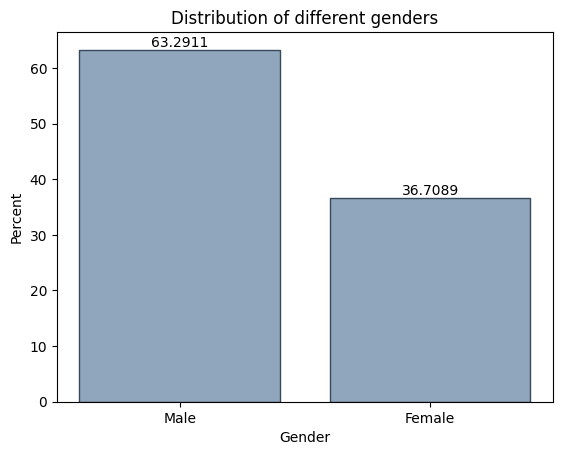

In [15]:
ax = sns.histplot(df_all['Gender'], color=colors[2], shrink=0.8, edgecolor=colors[-1], stat='percent')
ax.set_title('Distribution of different genders')
ax.bar_label(ax.containers[0])
plt.show()

In [16]:
str_numbers = [str(i) for i in range(100)]
numbers = [i for i in range(100)]
df_all['Age'] = df_all['Age'].replace(str_numbers, numbers)
m = df_all['Age'].mean()
s = df_all['Age'].std()
print(f'For the whole dataset:\nMean: {m:.3f}\nStandard Deviation: {s:.3f}\n')

comfortable['Age'] = comfortable['Age'].replace(str_numbers, numbers)
non_comfortable['Age'] = non_comfortable['Age'].replace(str_numbers, numbers)
m = comfortable['Age'].mean()
s = comfortable['Age'].std()
print(f'For comfortable people:\nMean: {m:.3f}\nStandard Deviation: {s:.3f}\n')
m = non_comfortable['Age'].mean()
s = non_comfortable['Age'].std()
print(f'For non-comfortable people:\nMean: {m:.3f}\nStandard Deviation: {s:.3f}\n')

For the whole dataset:
Mean: 26.823
Standard Deviation: 9.778

For comfortable people:
Mean: 25.841
Standard Deviation: 8.136

For non-comfortable people:
Mean: 28.057
Standard Deviation: 11.427



/var/folders/cn/c0p60trs3m1bpx84thnx5yjm0000gn/T/ipykernel_18565/2969386396.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_all['Age'] = df_all['Age'].replace(str_numbers, numbers)
/var/folders/cn/c0p60trs3m1bpx84thnx5yjm0000gn/T/ipykernel_18565/2969386396.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comfortable['Age'] = comfortable['Age'].replace(str_numbers, numbers)
/var/folders/cn/c0p60trs3m1bpx84thnx5yjm0000gn/T/ipykernel_18565/2969386396.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

/var/folders/cn/c0p60trs3m1bpx84thnx5yjm0000gn/T/ipykernel_18565/1077853705.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=60)


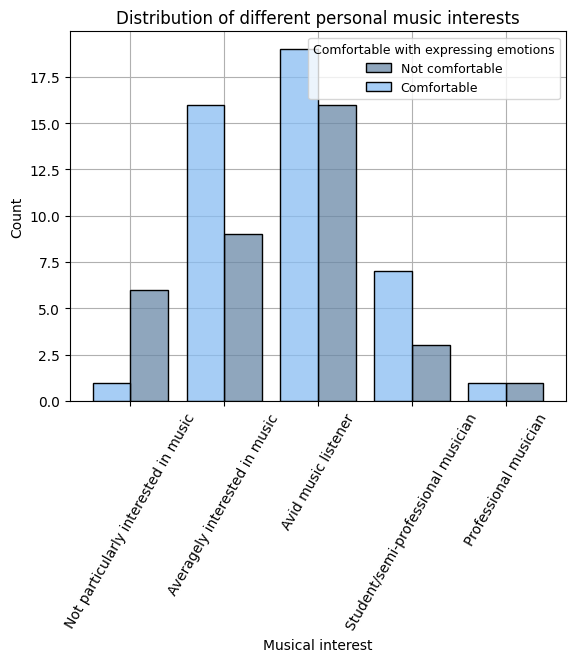

In [17]:
order = [
    'Not particularly interested in music', 
    'Averagely interested in music', 
    'Avid music listener', 
    'Student/semi-professional musician', 
    'Professional musician']

to_plot = grouped_df_all.copy()
to_plot = to_plot.drop_duplicates(subset='Participant_ID')
to_plot['Personal description'] = pd.Categorical(to_plot['Personal description'], categories=order, ordered=True)

ax = sns.histplot(data=to_plot, x='Personal description', hue='Comfortable with expressing emotions', palette=colors[1:3], multiple="dodge", shrink=0.8, zorder=3)
ax.set_title('Distribution of different personal music interests')
ax.set_xlabel('Musical interest')
ax.set_xticklabels(ax.get_xticklabels(),rotation=60)
ax.grid(True, zorder=0)
ax.legend(title="Comfortable with expressing emotions", fontsize=9, title_fontsize=9, labels=['Not comfortable', 'Comfortable'])
plt.show()

/var/folders/cn/c0p60trs3m1bpx84thnx5yjm0000gn/T/ipykernel_18565/71898497.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_all_numeric = df_all.replace(['ILLIAC', 'CYSP', 'ALICE', 'VOYAGER'], [0, 1, 2, 3])
/var/folders/cn/c0p60trs3m1bpx84thnx5yjm0000gn/T/ipykernel_18565/71898497.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_all_numeric = df_all_numeric.replace(order, [0, 1, 2, 3, 4])
/var/folders/cn/c0p60trs3m1bpx84thnx5yjm0000gn/T/ipykernel_18565/71898497.py:3: FutureWarning: Downcasting behavior in `replace` is de

<Axes: >

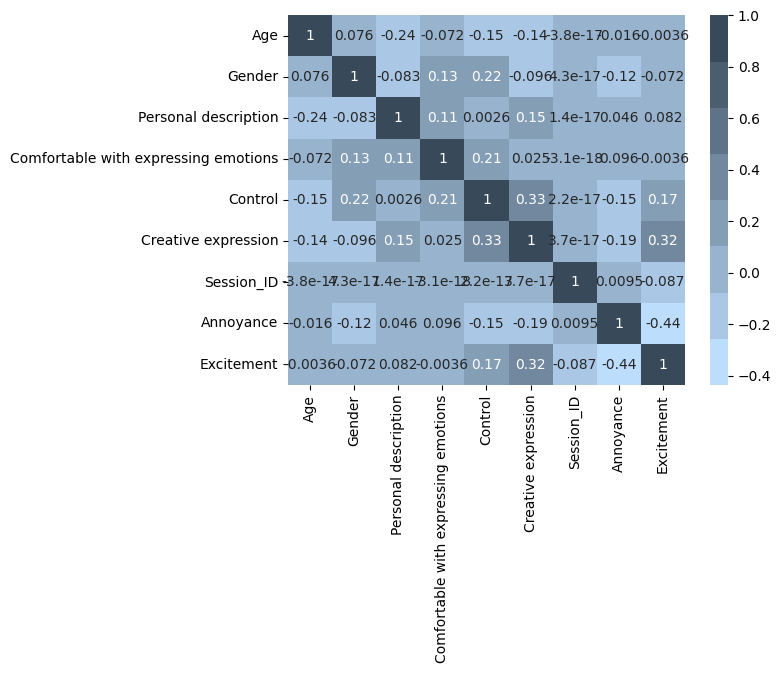

In [18]:
df_all_numeric = df_all.replace(['ILLIAC', 'CYSP', 'ALICE', 'VOYAGER'], [0, 1, 2, 3])
df_all_numeric = df_all_numeric.replace(order, [0, 1, 2, 3, 4])
df_all_numeric = df_all_numeric.replace(['Male', 'Female'], [0, 1])
df_all_numeric = df_all_numeric.drop(['Participant_ID', '_merge'], axis=1)
df_all_numeric = df_all_numeric.replace(['0', '1', '2', '3', '4', '5'], [0, 1, 2, 3, 4, 5])

sns.heatmap(df_all_numeric.corr(), annot=True, cmap=color_palett)

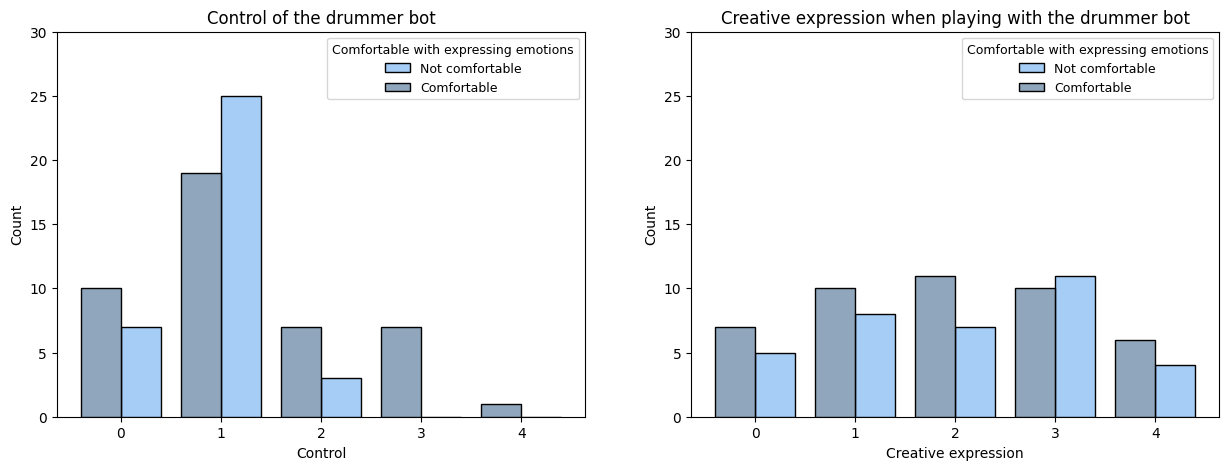

In [19]:
# Control and creative experience
to_plot = to_plot.replace([0, 1, 2, 3, 4, 5], ['0', '1', '2', '3', '4', '5'])
order = ['0', '1', '2', '3', '4', '5']
to_plot['Control'] = pd.Categorical(to_plot['Control'], categories=order, ordered=True)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data=to_plot, x='Control', hue='Comfortable with expressing emotions', ax=axs[0], palette=[colors[2], colors[1]], multiple="dodge", shrink=0.8, zorder=3)
axs[0].set_ylim(0, 30)
axs[0].set_title('Control of the drummer bot')
axs[0].legend(title="Comfortable with expressing emotions", fontsize=9, title_fontsize=9, labels=['Not comfortable', 'Comfortable'])

to_plot['Creative expression'] = pd.Categorical(to_plot['Creative expression'], categories=order, ordered=True)
sns.histplot(data=to_plot, x='Creative expression', hue='Comfortable with expressing emotions', ax=axs[1], palette=[colors[2], colors[1]], multiple="dodge", shrink=0.8, zorder=3)
axs[1].set_ylim(0, 30)
axs[1].set_title('Creative expression when playing with the drummer bot')
axs[1].legend(title="Comfortable with expressing emotions", fontsize=9, title_fontsize=9, labels=['Not comfortable', 'Comfortable'])

plt.show()

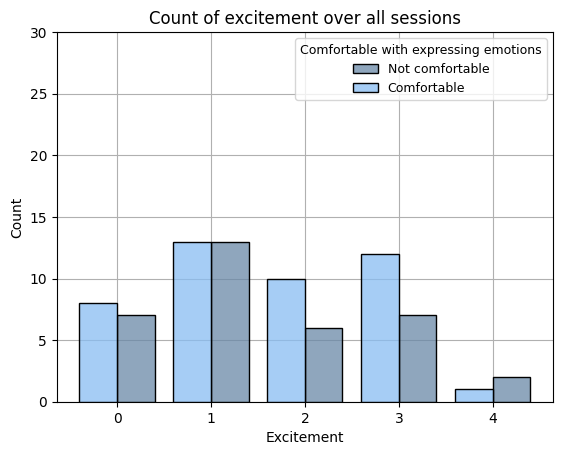

In [20]:
to_plot['Excitement'] = pd.Categorical(to_plot['Excitement'], categories=order, ordered=True)

ax = sns.histplot(data=to_plot, x='Excitement', hue='Comfortable with expressing emotions', palette=colors[1:3], multiple="dodge", shrink=0.8, zorder=3)
ax.set_title('Count of excitement over all sessions')
ax.set_xlabel('Excitement')
ax.set_ylim(0, 30)
ax.grid(True, zorder=0)
ax.legend(title="Comfortable with expressing emotions", fontsize=9, title_fontsize=9, labels=['Not comfortable', 'Comfortable'])
plt.show()

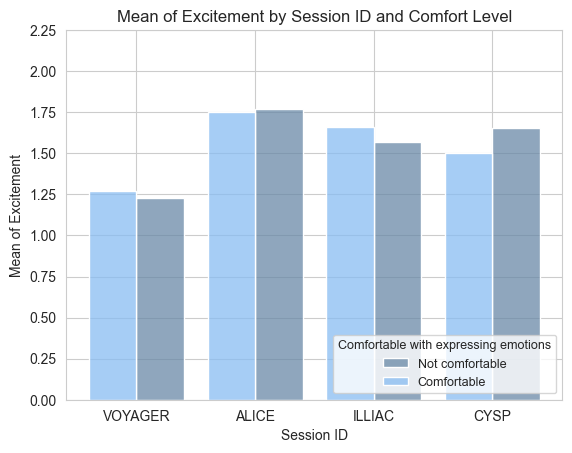

In [21]:
aggregated_data = grouped_df_all.groupby(['Session_ID', 'Comfortable with expressing emotions'], as_index=False)['Excitement'].mean()

order = ['VOYAGER', 'ALICE', 'ILLIAC', 'CYSP']
aggregated_data['Session_ID'] = pd.Categorical(aggregated_data['Session_ID'], categories=order, ordered=True)

sns.set_style('whitegrid')
ax = sns.histplot(data=aggregated_data, x='Session_ID', weights='Excitement', hue='Comfortable with expressing emotions', discrete=True, multiple='dodge', palette=colors[1:3], shrink=0.8)
ax.legend(title="Comfortable with expressing emotions", fontsize=9, title_fontsize=9, labels=['Not comfortable', 'Comfortable'], loc='lower right')
ax.set_ylabel("Mean of Excitement")
ax.set_xlabel("Session ID")
ax.set_title("Mean of Excitement by Session ID and Comfort Level")
ax.set_ylim(0, 2.25)
plt.show()


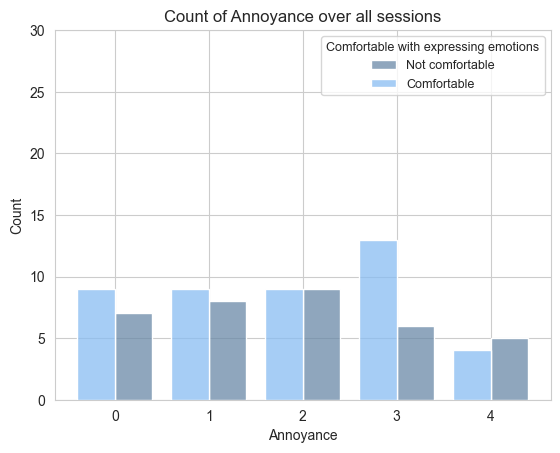

In [22]:
order = ['0', '1', '2', '3', '4', '5']
to_plot['Annoyance'] = pd.Categorical(to_plot['Annoyance'], categories=order, ordered=True)

ax = sns.histplot(data=to_plot, x='Annoyance', hue='Comfortable with expressing emotions', multiple="dodge", palette=colors[1:3], shrink=0.8, zorder=3)
ax.set_title('Count of Annoyance over all sessions')
ax.set_xlabel('Annoyance')
ax.set_ylim(0, 30)
ax.grid(True, zorder=0)
ax.legend(title="Comfortable with expressing emotions", fontsize=9, title_fontsize=9, labels=['Not comfortable', 'Comfortable'])
plt.show()

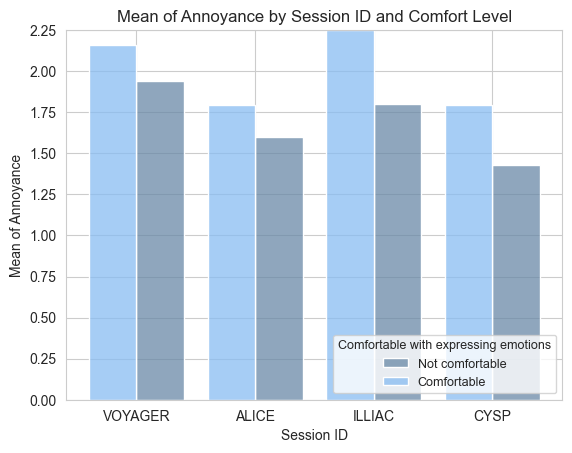

In [23]:
aggregated_data = grouped_df_all.groupby(['Session_ID', 'Comfortable with expressing emotions'], as_index=False)['Annoyance'].mean()

order = ['VOYAGER', 'ALICE', 'ILLIAC', 'CYSP']
aggregated_data['Session_ID'] = pd.Categorical(aggregated_data['Session_ID'], categories=order, ordered=True)

sns.set_style('whitegrid')
ax = sns.histplot(data=aggregated_data, x='Session_ID', weights='Annoyance', hue='Comfortable with expressing emotions', discrete=True, multiple='dodge', palette=colors[1:3], shrink=0.8)
ax.legend(title="Comfortable with expressing emotions", fontsize=9, title_fontsize=9, labels=['Not comfortable', 'Comfortable'], loc='lower right')
ax.set_ylabel("Mean of Annoyance")
ax.set_xlabel("Session ID")
ax.set_title("Mean of Annoyance by Session ID and Comfort Level")
ax.set_ylim(0, 2.25)
plt.show()

## ANOVA analysis

### During analysis

In [24]:
# Excitement
result_non_comfortable = AnovaRM(data=non_comfortable, depvar='Excitement', subject='Participant_ID', within=['Session_ID']).fit()
print('RM ANOVA for non-comfortable people:')
print(result_non_comfortable)

result_comfortable = AnovaRM(data=comfortable, depvar='Excitement', subject='Participant_ID', within=['Session_ID']).fit()
print('RM ANOVA for comfortable people:')
print(result_comfortable)

result = AnovaRM(data=grouped_df_all, depvar='Excitement', subject='Participant_ID', within=['Session_ID']).fit()
print('RM ANOVA for all people:')
print(result)

RM ANOVA for non-comfortable people:
                  Anova
           F Value Num DF  Den DF  Pr > F
-----------------------------------------
Session_ID  2.8817 3.0000 102.0000 0.0395

RM ANOVA for comfortable people:
                  Anova
           F Value Num DF  Den DF  Pr > F
-----------------------------------------
Session_ID  2.3590 3.0000 129.0000 0.0746

RM ANOVA for all people:
                  Anova
           F Value Num DF  Den DF  Pr > F
-----------------------------------------
Session_ID  4.8727 3.0000 234.0000 0.0026



In [25]:
# Perform Tukey's HSD pairwise comparison
tukey_non_comfortable = pairwise_tukeyhsd(endog=non_comfortable['Excitement'], groups=non_comfortable['Session_ID'], alpha=0.05)
print(tukey_non_comfortable.summary())

tukey_all_excitement = pairwise_tukeyhsd(endog=grouped_df_all['Excitement'], groups=grouped_df_all['Session_ID'], alpha=0.05)
print(tukey_all_excitement.summary())

tukey_all_excitement = pairwise_tukeyhsd(endog=grouped_df_all['Excitement'], groups=grouped_df_all['Comfortable with expressing emotions'], alpha=0.05)
print(tukey_all_excitement.summary())

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2 meandiff p-adj   lower  upper  reject
----------------------------------------------------
 ALICE    CYSP  -0.1143 0.9734  -0.807 0.5784  False
 ALICE  ILLIAC     -0.2 0.8761 -0.8927 0.4927  False
 ALICE VOYAGER  -0.5429 0.1791 -1.2356 0.1499  False
  CYSP  ILLIAC  -0.0857 0.9884 -0.7784  0.607  False
  CYSP VOYAGER  -0.4286 0.3769 -1.1213 0.2641  False
ILLIAC VOYAGER  -0.3429 0.5725 -1.0356 0.3499  False
----------------------------------------------------
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2 meandiff p-adj   lower   upper  reject
-----------------------------------------------------
 ALICE    CYSP  -0.1899 0.7338 -0.6675  0.2877  False
 ALICE  ILLIAC  -0.1392 0.8753 -0.6168  0.3383  False
 ALICE VOYAGER  -0.5063 0.0329 -0.9839 -0.0287   True
  CYSP  ILLIAC   0.0506 0.9928  -0.427  0.5282  False
  CYSP VOYAGER  -0.3165 0.3194  -0.794  0.1611  False
ILLIAC VOYAGER  -0.3671 0.1957 -0.8447

In [26]:
# Annoyance
result_non_comfortable = AnovaRM(data=non_comfortable, depvar='Annoyance', subject='Participant_ID', within=['Session_ID']).fit()
print('RM ANOVA for non-comfortable people:')
print(result_non_comfortable)

result_comfortable = AnovaRM(data=comfortable, depvar='Annoyance', subject='Participant_ID', within=['Session_ID']).fit()
print('RM ANOVA for comfortable people:')
print(result_comfortable)


f_statistic, p_value = stats.f_oneway(non_comfortable['Annoyance'], comfortable['Annoyance'])

print(f'F-statistic: {f_statistic:.3f}')
print(f'P-value: {p_value:.3f} > 0.05')

# Perform Tukey's HSD
tukey = pairwise_tukeyhsd(endog=grouped_df_all['Annoyance'], groups=grouped_df_all['Comfortable with expressing emotions'], alpha=0.05)
print(tukey.summary())

RM ANOVA for non-comfortable people:
                  Anova
           F Value Num DF  Den DF  Pr > F
-----------------------------------------
Session_ID  1.8623 3.0000 102.0000 0.1407

RM ANOVA for comfortable people:
                  Anova
           F Value Num DF  Den DF  Pr > F
-----------------------------------------
Session_ID  3.0336 3.0000 129.0000 0.0317

F-statistic: 4.141
P-value: 0.043 > 0.05
       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
   group1        group2     meandiff p-adj   lower   upper  reject
------------------------------------------------------------------
Comfortable Not comfortable  -0.3071 0.0427 -0.6041 -0.0102   True
------------------------------------------------------------------


In [27]:
# Control
f_statistic, p_value = stats.f_oneway(non_comfortable['Control'], comfortable['Control'])

print(f'F-statistic: {f_statistic:.3f}')
print(f'P-value: {p_value:.3f} < 0.05')

tukey = pairwise_tukeyhsd(endog=grouped_df_all['Control'], groups=grouped_df_all['Comfortable with expressing emotions'], alpha=0.05)
print(tukey.summary())

F-statistic: 19.374
P-value: 0.000 < 0.05
       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1        group2     meandiff p-adj  lower   upper  reject
-----------------------------------------------------------------
Comfortable Not comfortable  -0.4325   0.0 -0.6258 -0.2392   True
-----------------------------------------------------------------


In [28]:
# Creative expression
f_statistic, p_value = stats.f_oneway(non_comfortable['Creative expression'], comfortable['Creative expression'])

print(f'F-statistic: {f_statistic:.3f}')
print(f'P-value: {p_value:.3f} > 0.05')

tukey = pairwise_tukeyhsd(endog=grouped_df_all['Creative expression'], groups=grouped_df_all['Comfortable with expressing emotions'], alpha=0.05)
print(tukey.summary())

F-statistic: 0.264
P-value: 0.608 > 0.05
       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1        group2     meandiff p-adj   lower  upper  reject
-----------------------------------------------------------------
Comfortable Not comfortable    0.074 0.6075 -0.2093 0.3573  False
-----------------------------------------------------------------


In [29]:
# Gender
comfortable_gender = comfortable.replace(['Male', 'Female'], [0, 1])
non_comfortable_gender = non_comfortable.replace(['Male', 'Female'], [0, 1])
f_statistic, p_value = stats.f_oneway(non_comfortable_gender['Gender'], comfortable_gender['Gender'])

print(f'F-statistic: {f_statistic:.3f}')
print(f'P-value: {p_value:.3f} < 0.05')

grouped_df_all_grouped = grouped_df_all.replace(['Male', 'Female'], [0, 1])
tukey = pairwise_tukeyhsd(endog=grouped_df_all_grouped['Gender'], groups=grouped_df_all_grouped['Comfortable with expressing emotions'], alpha=0.05)
print(tukey.summary())

F-statistic: 22.077
P-value: 0.000 < 0.05
       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1        group2     meandiff p-adj  lower   upper  reject
-----------------------------------------------------------------
Comfortable Not comfortable  -0.2487   0.0 -0.3528 -0.1446   True
-----------------------------------------------------------------


/var/folders/cn/c0p60trs3m1bpx84thnx5yjm0000gn/T/ipykernel_18565/2453372486.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comfortable_gender = comfortable.replace(['Male', 'Female'], [0, 1])
/var/folders/cn/c0p60trs3m1bpx84thnx5yjm0000gn/T/ipykernel_18565/2453372486.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  non_comfortable_gender = non_comfortable.replace(['Male', 'Female'], [0, 1])
/var/folders/cn/c0p60trs3m1bpx84thnx5yjm0000gn/T/ipykernel_18565/2453372486.py:9: FutureWarning: Downcasting behavior in `replace` is 

In [30]:
# Session ID and excitement
alice = df_all[df_all['Session_ID'] == 'ALICE']
illiac = df_all[df_all['Session_ID'] == 'ILLIAC']
cysp = df_all[df_all['Session_ID'] == 'CYSP']
voyager = df_all[df_all['Session_ID'] == 'VOYAGER']

f_statistic, p_value = stats.f_oneway(alice['Excitement'], illiac['Excitement'], cysp['Excitement'], voyager['Excitement'])

print(f'F-statistic: {f_statistic:.3f}')
print(f'P-value: {p_value:.3f} > 0.05')

F-statistic: 2.678
P-value: 0.047 > 0.05


In [31]:
# Session ID and annoyance
f_statistic, p_value = stats.f_oneway(alice['Annoyance'], illiac['Annoyance'], cysp['Annoyance'], voyager['Annoyance'])

print(f'F-statistic: {f_statistic:.3f}')
print(f'P-value: {p_value:.3f} > 0.05')

F-statistic: 2.258
P-value: 0.082 > 0.05


### Post questions

In [35]:
# Control
data = grouped_df_all.rename(columns={'Comfortable with expressing emotions': 'Comfortability', 'Personal description': 'Description', 'Creative expression': 'Expression'})
model = ols('Control ~ C(Gender) + C(Description) + C(Comfortability) + C(Gender):C(Description) + C(Gender):C(Comfortability) + C(Description):C(Comfortability) + C(Gender):C(Description):C(Comfortability)', data=data).fit()
sm.stats.anova_lm(model, typ=2)


/Users/myrthetilleman/Documents/IN9060_code/IN5060-assignment3/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 3
  warnings.warn('covariance of constraints does not have full '
/Users/myrthetilleman/Documents/IN9060_code/IN5060-assignment3/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 3
  warnings.warn('covariance of constraints does not have full '
/Users/myrthetilleman/Documents/IN9060_code/IN5060-assignment3/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 3
  warnings.warn('covariance of constraints does not have full '


,sum_sq,df,F,PR(>F)
C(Gender),5.824741,1.0,9.064111,0.002829
C(Description),0.673075,4.0,0.261850,0.852854
C(Comfortability),7.857839,1.0,12.227895,0.000542
C(Gender):C(Description),17.553018,4.0,6.828737,0.000183
C(Gender):C(Comfortability),1.908651,1.0,2.970128,0.085849
C(Description):C(Comfortability),2.344027,4.0,0.911908,0.435519
C(Gender):C(Description):C(Comfortability),20.711764,4.0,8.057600,0.000004
Residual,192.142125,299.0,NaN,NaN


In [36]:
# Creative expression
model_expression = ols('Expression ~ C(Gender) + C(Description) + C(Comfortability) + C(Gender):C(Description) + C(Gender):C(Comfortability) + C(Description):C(Comfortability) + C(Gender):C(Description):C(Comfortability)', data=data).fit()
sm.stats.anova_lm(model_expression, typ=2)

/Users/myrthetilleman/Documents/IN9060_code/IN5060-assignment3/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 3
  warnings.warn('covariance of constraints does not have full '
/Users/myrthetilleman/Documents/IN9060_code/IN5060-assignment3/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 3
  warnings.warn('covariance of constraints does not have full '
/Users/myrthetilleman/Documents/IN9060_code/IN5060-assignment3/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 3
  warnings.warn('covariance of constraints does not have full '


,sum_sq,df,F,PR(>F)
C(Gender),6.214468,1.0,4.824832,2.882003e-02
C(Description),15.988258,4.0,3.103269,2.695322e-02
C(Comfortability),0.303527,1.0,0.235655,6.277179e-01
C(Gender):C(Description),31.539457,4.0,6.121706,4.716893e-04
C(Gender):C(Comfortability),0.295104,1.0,0.229115,6.325308e-01
C(Description):C(Comfortability),23.710646,4.0,4.602159,3.637548e-03
C(Gender):C(Description):C(Comfortability),61.641395,4.0,11.964394,4.957251e-09
Residual,385.117216,299.0,NaN,NaN


## Notes from presentations


 * Heatmap could be a good supply?
 * Need to provide a confidence interval (ours is 95%)
 * Need much information about data to get a overview of the whole data set
 * Group pro and semi-pro in the start of the analysis and argue why we do it
 * Maybe we can add another question from the during questionaires?
 * Can explain more how the user studies were conducted
 * ! Balance in the data !

# What are we doing?

Ihne:
 * Boxplots of annoyance and excitement
 * Boxplots of post questions

Myrthe:
 * ANOVA 😎